**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/time-series-as-features).**

---


# Introduction #

Run this cell to set everything up!

In [42]:
# Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex4 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings
# from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from warnings import simplefilter
from scipy.signal import periodogram


from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

comp_dir = Path('data/')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        # 'store_nbr': 'uint32',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

# print(" range of the neighbor: ", store_sales.store_nbr.min(), store_sales.store_nbr.max())
print(" range of the onporomotion: ", store_sales.onpromotion.min(), store_sales.onpromotion.max())
print(store_sales.family.unique())


print("1=====", store_sales.head())
# print("1=====", store_sales.tail())

store_sales['date'] = store_sales.date.dt.to_period('D')
print("2=====", store_sales.head())

store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
print("3=====", store_sales.head())
# print("4=====", store_sales.tail())

print("create new dataframe")
print(store_sales.groupby(['family', 'date']).mean().unstack('family').head() )

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

print("5=====", family_sales.head())



 range of the onporomotion:  0 741
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
1=====         date store_nbr      family  sales  onpromotion
0 2013-01-01         1  AUTOMOTIVE    0.0            0
1 2013-01-01         1   BABY CARE    0.0            0
2 2013-01-01         1      BEAUTY    0.0            0
3 2013-01-01         1   BEVERAGES    0.0            0
4 2013-01-01         1       BOOKS    0.0            0
2=====          date store_nbr      family  sales  onpromotion
0  2013-01-01         1  AUTOMOTIVE    0.0            0
1  2013-01-01         1   BABY CARE    0.0            0
2  2013-01-01         1      BEAUTY    0.0            0
3  2013-01-01         1   BEVERAGES    0.0            0
4  2013-01-01         1       BOO

----------------------------------------------------------------------------

onpromotion columns contains the number of iterms on special promotion that day.

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely *cyclic* behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize *Supply Sales*. We'll store the result in a variable `y_deseason`.

final dataset: 
                                 sales                onpromotion
family     SCHOOL AND OFFICE SUPPLIES SCHOOL AND OFFICE SUPPLIES
date                                                            
2017-01-01                   0.000000                        0.0
2017-01-02                   2.925926                        0.0
2017-01-03                   2.018518                        0.0
2017-01-04                   1.722222                        0.0
2017-01-05                   1.425926                        0.0
final y: 
 date
2017-01-01    0.000000
2017-01-02    2.925926
2017-01-03    2.018518
2017-01-04    1.722222
2017-01-05    1.425926
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, dtype: float32

x_time 1: 
             const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2017-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0    2.0     1.0 

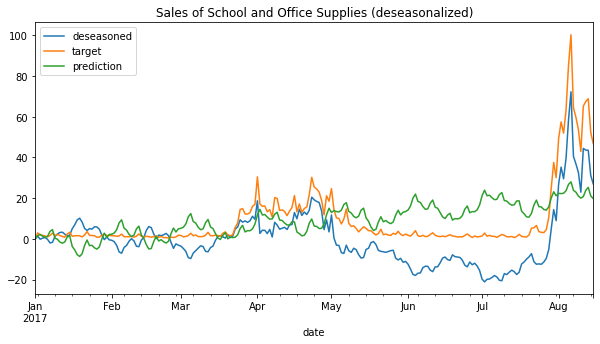

In [33]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']

print("final dataset: \n",supply_sales.head())

y = supply_sales.loc[:, 'sales'].squeeze()


print("final y: \n",y.head())


# find seasonality of the data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier], # monthly seasonality of order 4
)

X_time = dp.in_sample() # create features (Fourier terms)

# print("\nx_time 0: \n", X_time.head(30))

X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

print("\nx_time 1: \n", X_time.head(30))

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot(label='deseasoned', figsize=(10,5))
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

ax=y.plot(label='target')
ax=pd.Series(model.predict(X_time), index=y.index).plot(label='prediction')
# ax.legend(['deseasoned', 'target','prediction'])
ax.legend()


Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

# 1) Plotting cycles

Create a seven-day moving average from `y`, the series of supply sales. Use a centered window, but don't set the `min_periods` argument.

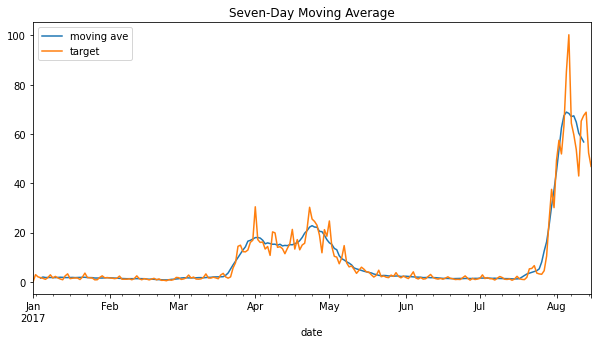

In [35]:
# YOUR CODE HERE
y_ma = y.rolling(window=7, center=True).mean()

# Plot
ax = y_ma.plot(label='moving ave', figsize=(10,5))
ax.set_title("Seven-Day Moving Average");

ax = y.plot(label='target', figsize=(10,5))
ax.legend()


# Check your answer
# q_1.check()

In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

-------------------------------------------------------------------------------

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

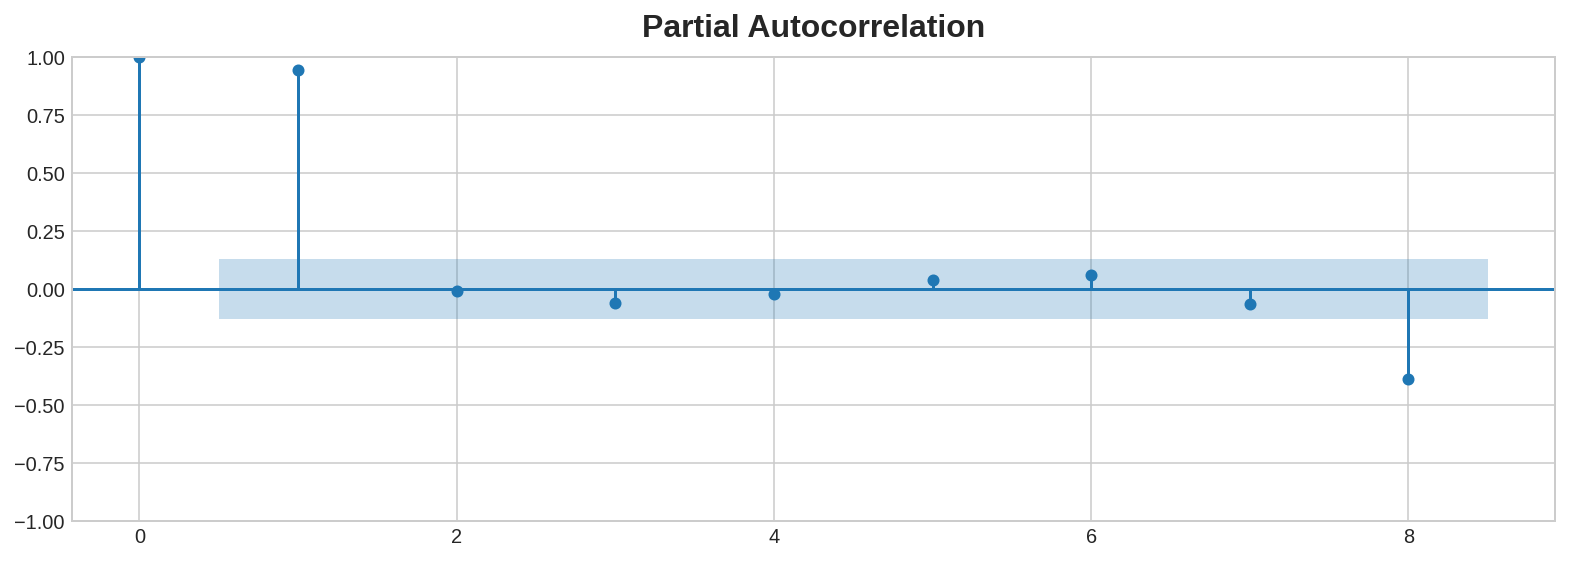

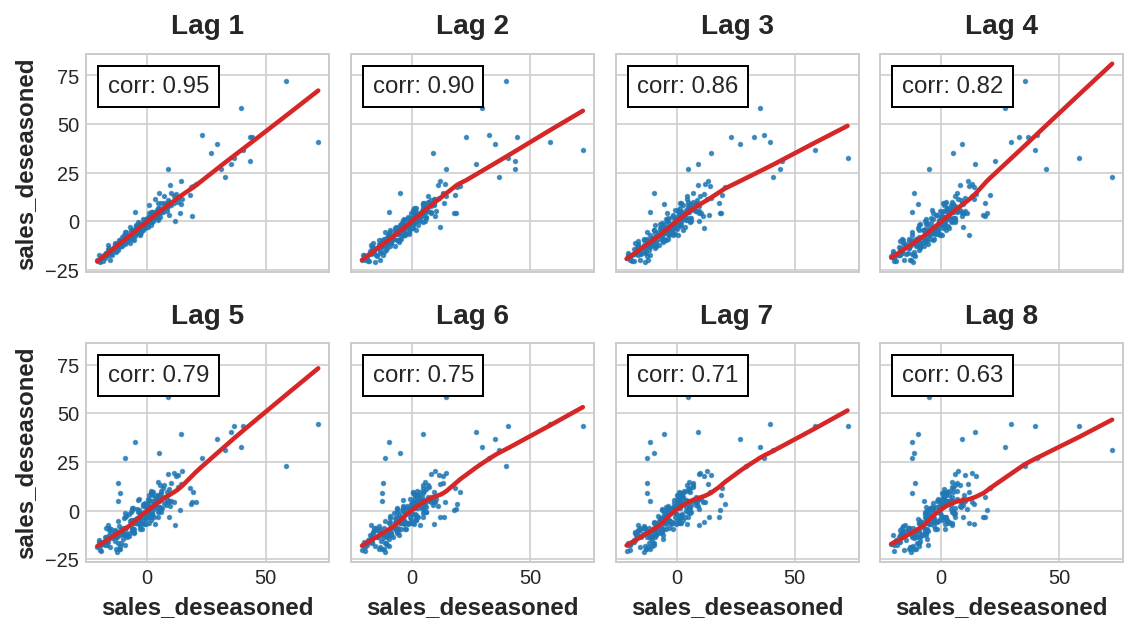

In [37]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

# 2) Examine serial dependence in *Store Sales*

Are any of the lags significant according to the correlogram? Does the lag plot suggest any relationships that weren't apparent from the correlogram?

After you've thought about your answer, run the next cell.

In [ ]:
# View the solution (Run this cell to receive credit!)
# q_2.check()

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.



-------------------------------------------------------------------------------

Recall from the tutorial that a *leading indicator* is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for `onpromotion` plotted against sales of school and office supplies.

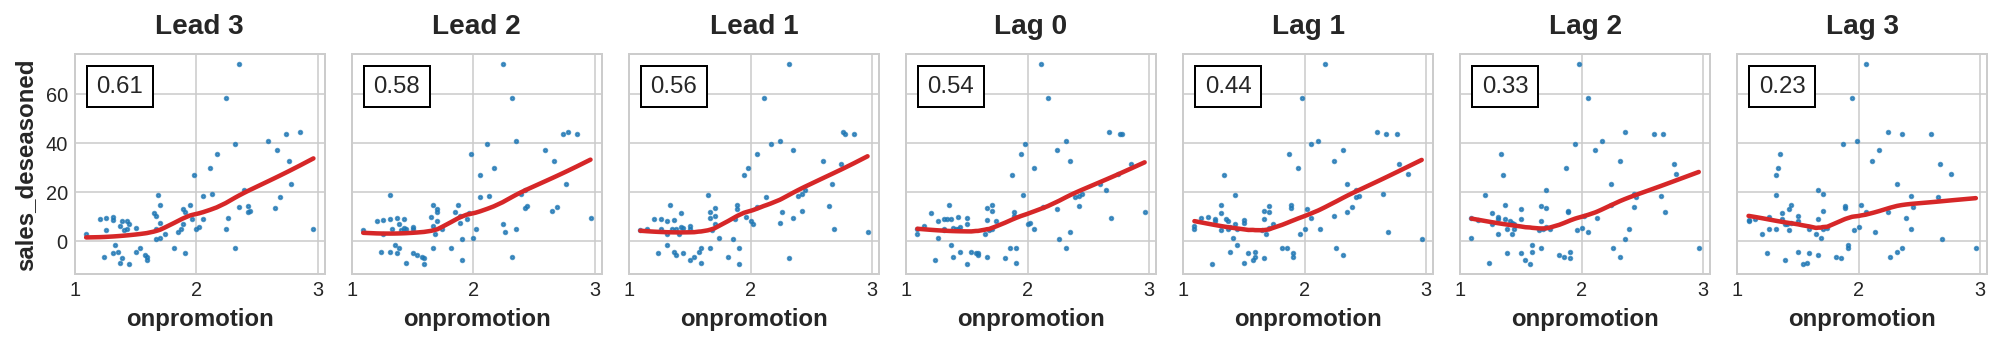

In [43]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1); # I don't know what lead here means.
# plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, nrows=1);

# 3) Examine time series features

Does it appear that either leading or lagging values of `onpromotion` could be useful as a feature?

In [ ]:
# q_3.check()

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

-------------------------------------------------------------------------------

# 4) Create time series features

Create the features indicated in the solution to Question 3. If no features from that series would be useful, use an empty dataframe `pd.DataFrame()` as your answer.

In [46]:
# YOUR CODE HERE: Make features from `y_deseason`

def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# what is it?
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

X_lags = make_lags(y_deseason, lags=1)


# YOUR CODE HERE: Make features from `onpromotion`
# You may want to use `pd.concat`

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

# Check your answer
# q_4.check()

In [ ]:
# Lines below will give you a hint or solution code
#q_4.hint()
#q_4.solution()

Use the code in the next cell if you'd like to see predictions from the resulting model.

Training RMSLE: 0.83417
Validation RMSLE: 1.17316


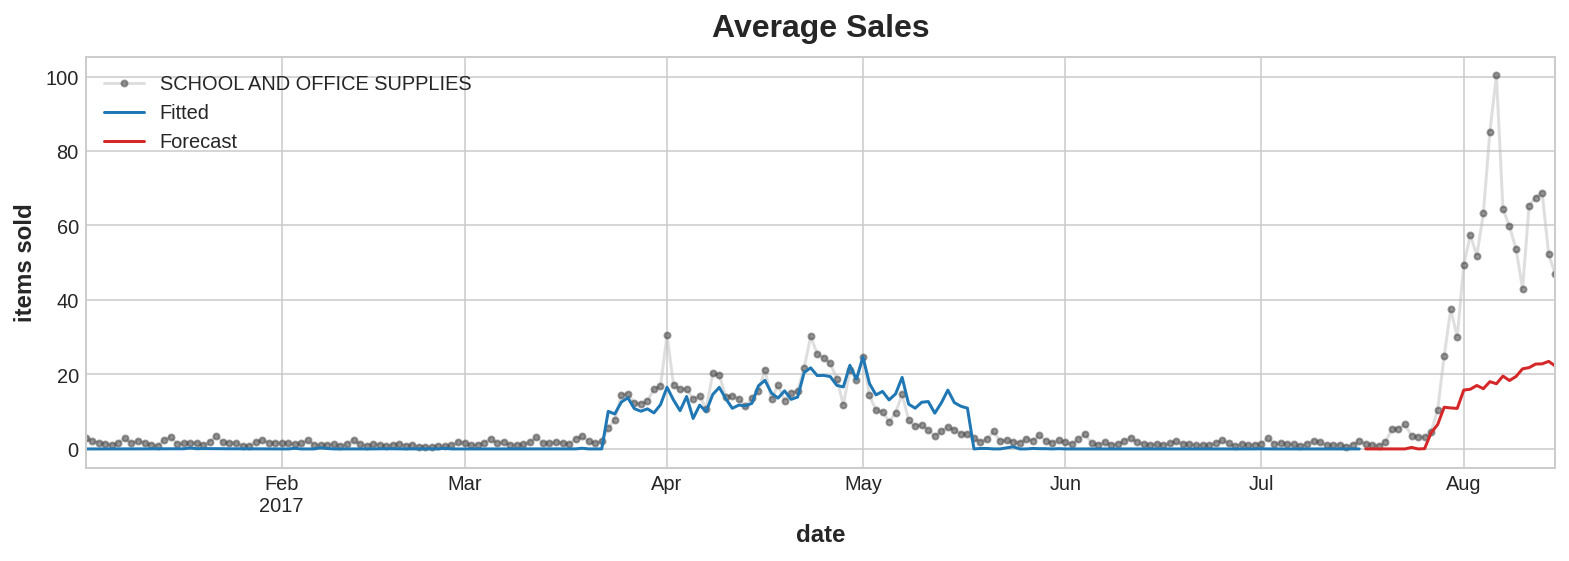

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

-------------------------------------------------------------------------------

Winners of Kaggle forecasting competitions have often included moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

In Lesson 2 you learned how to compute moving averages to estimate trends. Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the `rolling` method. Second, the target should be lagged a step.

# 5) Create statistical features

Edit the code in the next cell to create the following features:
- 14-day rolling median (`median`) of lagged target
- 7-day rolling standard deviation (`std`) of lagged target
- 7-day sum (`sum`) of items "on promotion", with centered window

In [1]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# YOUR CODE HERE: 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()


# Check your answer
# q_5.check()

NameError: name 'supply_sales' is not defined

In [ ]:
# Lines below will give you a hint or solution code
#q_5.hint()
#q_5.solution()

Check out the Pandas [`Window` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/window.html) for more statistics you can compute. Also try "exponential weighted" windows by using `ewm` in place of `rolling`; exponential decay is often a more realistic representation of how effects propagate over time.

# Keep Going #

[**Create hybrid forecasters**](https://www.kaggle.com/ryanholbrook/hybrid-models) and combine the strengths of two machine learning algorithms.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*